In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [2]:
def set_params(params, guess_flux, yerrs):
    """
    Creating a GaussianProcess object for a Matern32Term kernel. 

    Parameters
    ----------
    params : array_like
        Containing Matern32Term kernel parameters.
        _sigma, _rho = params 
    
    guess_flux : array_like
        Containing the physical (batman) model flux.
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    gp : GaussianProcess
        GaussianProcess object.

    """
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=guess_flux)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [3]:
TIC = 'TIC 292152376' #HAT-P-32b / TIC 292152376 

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc_collection[0] #Choose one
lc = lc.remove_nans()
lc = lc.normalize()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 292152376" SECTOR=58 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 292152376" SECTOR=58 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [4]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2882.333964365241,9.9655360e-01,3.7049574e-03,4.7688745e-03,7149060,1716.32187,80.52453,7.0599927e+03,2.5440413e+01,2.1701130e+03,1.0319659e+01,7.7999526e+03,2.8998432e+01,0,———,———,———,———,1716.32187,2.8485591e-03,80.52453,2.8539505e-03,-2.4717418e-02,1.2510775e-01
2882.3341958498736,1.0005392e+00,3.7315427e-03,4.7688778e-03,7149061,1716.33853,80.46161,7.0870864e+03,2.5622967e+01,2.1727319e+03,1.0671177e+01,7.8311475e+03,2.9206514e+01,0,———,———,———,———,1716.33853,2.8341755e-03,80.46161,2.8514788e-03,-8.1958789e-03,5.6984786e-02
2882.3344273345065,1.0009676e+00,3.7104699e-03,4.7688810e-03,7149062,1716.32849,80.48191,7.0947788e+03,2.5478268e+01,2.1612063e+03,1.0317609e+01,7.8345005e+03,2.9041578e+01,0,———,———,———,———,1716.32849,2.8365436e-03,80.48191,2.8516736e-03,-1.9961720e-02,7.3843673e-02
2882.334658819605,1.0037433e+00,3.7128427e-03,4.7688847e-03,7149063,1716.32887,80.44299,7.1072979e+03,2.5494562e+01,2.1604155e+03,1.0313842e+01,7.8562256e+03,2.9060150e+01,0,———,———,———,———,1716.32887,2.8296222e-03,80.44299,2.8541633e-03,-1.3911680e-02,2.6328735e-02
2882.3348903042374,9.9777985e-01,3.7026214e-03,4.7688880e-03,7149064,1716.32822,80.46002,7.0684326e+03,2.5424376e+01,2.1551033e+03,1.0308329e+01,7.8095503e+03,2.8980148e+01,0,———,———,———,———,1716.32822,2.8385341e-03,80.46002,2.8603987e-03,-2.0426391e-02,5.3222023e-02
2882.3351217888708,1.0012350e+00,3.7071679e-03,4.7688913e-03,7149065,1716.34344,80.44623,7.0887871e+03,2.5455595e+01,2.1515276e+03,1.0308930e+01,7.8365933e+03,2.9015734e+01,0,———,———,———,———,1716.34344,2.8355604e-03,80.44623,2.8555314e-03,-1.3088383e-03,3.3316165e-02
2882.335353273503,1.0013655e+00,3.7118897e-03,4.7688945e-03,7149066,1716.33480,80.45680,7.0912593e+03,2.5488018e+01,2.1618015e+03,1.0333810e+01,7.8376152e+03,2.9052691e+01,0,———,———,———,———,1716.33480,2.8331680e-03,80.45680,2.8567284e-03,-5.8616074e-03,4.4737421e-02
2882.335584758136,9.9794042e-01,3.7034217e-03,4.7688978e-03,7149067,1716.31190,80.48907,7.0791191e+03,2.5429871e+01,2.1505105e+03,1.0289975e+01,7.8108071e+03,2.8986412e+01,0,———,———,———,———,1716.31190,2.8487025e-03,80.48907,2.8473190e-03,-3.8953446e-02,8.9025311e-02


In [5]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

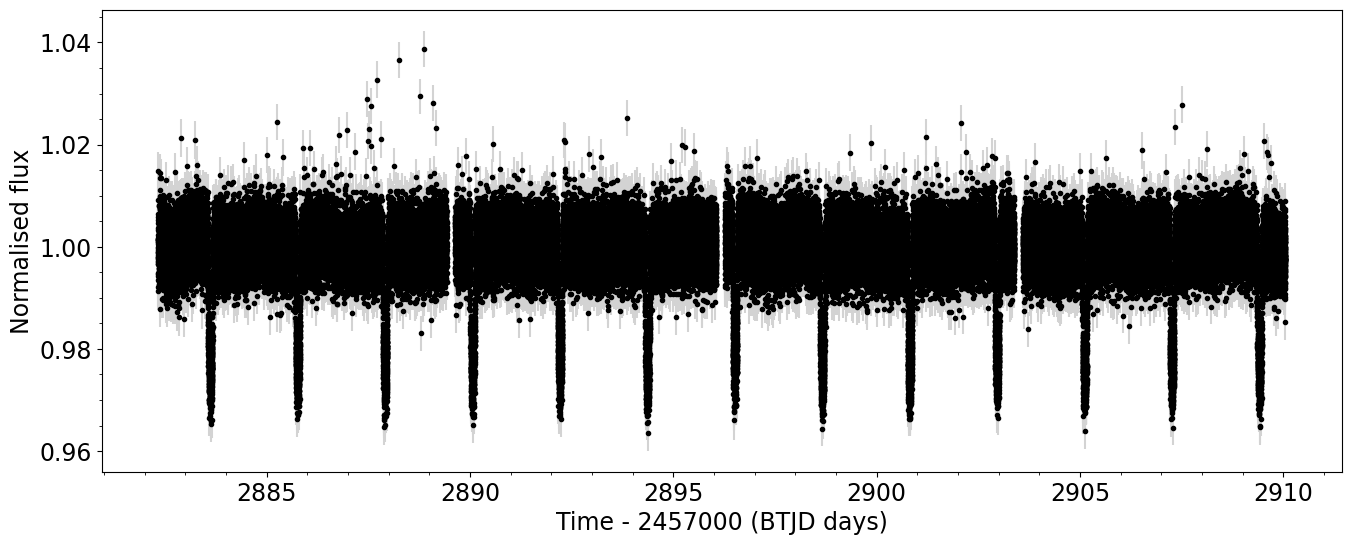

In [6]:
fig, ax = plt.subplots(1, figsize=(16,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [7]:
filename = "HAT_P_32b_free_ecc_gp_batman_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [8]:
#batman model
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R*
model_ecc = np.percentile(flat_samples[:, 5], 50) #Eccentricity

#GP model
model_sigma = np.percentile(flat_samples[:, 6], 50)
model_rho = np.percentile(flat_samples[:, 7], 50)

prior_Rs = 1.219 #R_sun Hartman et al. 2011

model_params = batman.TransitParams()
model_params.t0 = model_T0
model_params.per = model_per
model_params.rp = model_Rp
model_params.a = model_a
model_params.inc = model_inc
model_params.ecc = model_ecc
model_params.w = 50.0 #(Deg) Wang et al. 2019
model_params.limb_dark = "quadratic"
model_params.u = [0.2366419727326458, 0.2819412888558852] #Estimated by HAT_P_32b.ipynb

m = batman.TransitModel(model_params, t) #Use TESS time series, t
batman_model = m.light_curve(model_params)

In [9]:
gp = set_params([model_sigma, model_rho], batman_model, yerrs)

filename = "HAT_P_32b_model_flux.p"

if os.path.exists(filename) == True:
    with open(filename, "rb") as f:
        model_flux, variance = pickle.load(f)
    f.close()
else:
    model_flux = gp.predict(flux_data, t=t, return_var=False) #model flux = gp model + batman model
    # sigma = np.sqrt(variance)

    file = open(filename, "wb")
    pickle.dump([model_flux], file)
    file.close()

MemoryError: Unable to allocate 102. GiB for an array with shape (116995, 116995) and data type float64

In [ ]:
plt.plot(np.diff(t))

In [ ]:
plt.plot(range(len(t)), t)
plt.xlabel("Index number in lc.time.btjd")
plt.ylabel("Time - 2457000 (BTJD days)")

In [ ]:
for i, time in zip(range(len(t)), np.diff(t)):
    if time < 0:
        print(i)
        print(time, i)
        print(t[i])
print(t[116993], t[116994], t[116995], t[116996], t[116997])

In [ ]:
gp = set_params([model_sigma, model_rho], batman_model, yerrs)

model_flux, variance = gp.predict(flux_data, t=t, return_var=True)

In [ ]:
#batman + gp model

fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t, model_flux, color='Red', zorder=10)


# ax.set_xlim([min(t) - 1, max(t) + 1])
ax.set_ylim([0.967, 1.015])
ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [ ]:
#Detrending the flux data
gp_model = model_flux - batman_model
detrended_flux_data = flux_data - gp_model

In [ ]:
t_range = np.arange(min(t), max(t), 0.001388889) #0.001388889 days = 2 minutes

t_range_m = batman.TransitModel(model_params, t_range) #Use TESS time series, t
batman_model_extend_range = t_range_m.light_curve(model_params)

In [ ]:
#detrended flux

fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, detrended_flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t_range, batman_model_extend_range, color='Red', zorder=10)


# ax.set_xlim([min(t), max(t)])
ax.set_ylim([0.986, 1.01])
ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [ ]:
gp_batman_residuals = detrended_flux_data - model_flux

#Detrended flux data folding
lc_folded = lk.LightCurve(time=t, flux=detrended_flux_data, flux_err=yerrs).fold(model_per, model_T0)
t_folded = np.array(lc_folded.time.value)
detrended_flux_folded = np.array(lc_folded.flux)
yerrs_folded = np.array(lc_folded.flux_err)

#Phase folding model 
folded_model = lk.LightCurve(time=t, flux=batman_model).fold(model_per, model_T0)
folded_model_flux = np.array(folded_model.flux)
folded_model_time = np.array(folded_model.time.value)

#Phase folding residuals
folded_residuals = lk.LightCurve(time=t, flux=gp_batman_residuals).fold(model_per, model_T0)
folded_residuals_flux = np.array(folded_residuals.flux)
folded_residuals_time = np.array(folded_residuals.time.value)


In [ ]:
#Phased folded

#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(16, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t_folded, detrended_flux_folded, yerr=yerrs_folded,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0)
ax.plot(folded_model_time, folded_model_flux, color='red',label="Model", lw=2, zorder=10)

ax.set(ylabel="Normalised flux")
ax.set_ylim([0.986, 1.01])
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)


# Mirror y
axy = ax.twinx()
axy.set_ylim(ax.get_ylim())
axy.get_yaxis().set_ticklabels([])
axy.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axx = ax.twiny()
axx.set_xlim(ax.get_xlim())
axx.get_xaxis().set_ticklabels([])
axx.tick_params(which="both", direction="in")

axx.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axy.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(folded_residuals_time, folded_residuals_flux, color='black', s=5)
# ax_res.set_ylim((-max(abs(folded_residuals_flux))*1.2, max(abs(folded_residuals_flux)*1.2)))


ax_res.set(xlabel="Phase", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

# Mirror y
ax_res_y = ax_res.twinx()
ax_res_y.set_ylim(ax_res.get_ylim())
ax_res_y.get_yaxis().set_ticklabels([])
ax_res_y.tick_params(which="both", direction="in")

# Mirror x
ax_res_x = ax_res.twiny()
ax_res_x.set_xlim(ax_res.get_xlim())
ax_res_x.get_xaxis().set_ticklabels([])
ax_res_x.tick_params(which="both", direction="in")

ax_res_x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_y.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_x.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
batman_residuals = flux_data - batman_model

In [ ]:
"""
Batman model only w/ flux data
residuals
"""


#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(16, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0)
ax.plot(t_range, batman_model_extend_range, color='red',label="Model", lw=2, zorder=10)

ax.set(ylabel="Normalised flux")
ax.set_ylim([0.986, 1.01])
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

# Mirror y
axy = ax.twinx()
axy.set_ylim(ax.get_ylim())
axy.get_yaxis().set_ticklabels([])
axy.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axx = ax.twiny()
axx.set_xlim(ax.get_xlim())
axx.get_xaxis().set_ticklabels([])
axx.tick_params(which="both", direction="in")


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
axx.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axy.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

"""
Residuals panel
"""
ax_res.scatter(t, batman_residuals, color='black', s=5)
# ax_res.set_ylim((-max(abs(batman_residuals))*1.2, max(abs(batman_residuals)*1.2)))

ax_res.set(xlabel="Phase", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

# Mirror y
ax_res_y = ax_res.twinx()
ax_res_y.set_ylim(ax_res.get_ylim())
ax_res_y.get_yaxis().set_ticklabels([])
ax_res_y.tick_params(which="both", direction="in")

# Mirror x
ax_res_x = ax_res.twiny()
ax_res_x.set_xlim(ax_res.get_xlim())
ax_res_x.get_xaxis().set_ticklabels([])
ax_res_x.tick_params(which="both", direction="in")

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_y.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
"""
batman + gp model w/ flux data 
residuals
"""

#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(16, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0)
ax.plot(t, model_flux, color='red',label="Model", lw=2, zorder=10)

ax.set(ylabel="Normalised flux")
ax.set_ylim([0.986, 1.01])
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

# Mirror y
axy = ax.twinx()
axy.set_ylim(ax.get_ylim())
axy.get_yaxis().set_ticklabels([])
axy.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axx = ax.twiny()
axx.set_xlim(ax.get_xlim())
axx.get_xaxis().set_ticklabels([])
axx.tick_params(which="both", direction="in")


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
axx.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axy.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

"""
Residuals panel
"""
ax_res.scatter(t, gp_batman_residuals, color='black', s=5)
# ax_res.set_ylim((-max(abs(gp_batman_residuals))*1.2, max(abs(gp_batman_residuals)*1.2)))

ax_res.set(xlabel="Phase", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

# Mirror y
ax_res_y = ax_res.twinx()
ax_res_y.set_ylim(ax_res.get_ylim())
ax_res_y.get_yaxis().set_ticklabels([])
ax_res_y.tick_params(which="both", direction="in")

# Mirror x
ax_res_x = ax_res.twiny()
ax_res_x.set_xlim(ax_res.get_xlim())
ax_res_x.get_xaxis().set_ticklabels([])
ax_res_x.tick_params(which="both", direction="in")

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_y.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
detrended_batman_residuals = detrended_flux_data - batman_model

In [ ]:
"""
batman model w/ detrended flux
residuals
"""

#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(16, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, detrended_flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0)
ax.plot(t, batman_model, color='red',label="Model", lw=2, zorder=10)

ax.set(ylabel="Normalised flux")
ax.set_ylim([0.986, 1.01])
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

# Mirror y
axy = ax.twinx()
axy.set_ylim(ax.get_ylim())
axy.get_yaxis().set_ticklabels([])
axy.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axx = ax.twiny()
axx.set_xlim(ax.get_xlim())
axx.get_xaxis().set_ticklabels([])
axx.tick_params(which="both", direction="in")


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
axx.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axy.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

"""
Residuals panel
"""
ax_res.scatter(t, detrended_batman_residuals, color='black', s=5)
# ax_res.set_ylim((-max(abs(detrended_batman_residuals))*1.2, max(abs(detrended_batman_residuals)*1.2)))

ax_res.set(xlabel="Phase", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

# Mirror y
ax_res_y = ax_res.twinx()
ax_res_y.set_ylim(ax_res.get_ylim())
ax_res_y.get_yaxis().set_ticklabels([])
ax_res_y.tick_params(which="both", direction="in")

# Mirror x
ax_res_x = ax_res.twiny()
ax_res_x.set_xlim(ax_res.get_xlim())
ax_res_x.get_xaxis().set_ticklabels([])
ax_res_x.tick_params(which="both", direction="in")

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res_y.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()